<a href="https://colab.research.google.com/github/ecuadrafoy/PracticalMachineLearning/blob/master/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework: classify the origin of names using a character-level RNN

In this homework we will use an rnn-based model to perform classification. The goal is threefold:

1. Get more hands on with the preprocessing needed to perform text classification from A to Z. No preprocessing is done for you!
2. Use embeddings and RNNs in conjunction at the character level to perform classification.
3. Write a function that takes as input a string, and outputs the name of the predicted class.

However, here are guidelines to help you through all the steps:

1. Figure out the number of classes, and map the classes to integers (or one-hot vectors). This is needed for fitting the model and training it to do classification.
2. Use the keras tokenizer at the character level to tokenize your input into integer sequences.
3. Pad your sequences using the keras preprocessing tools.
4. Build a model that uses, minimally, an embedding layer, an RNN (of your choice) and a dense layer to output the logits or probabilities for the target classes (name origins).
5. Fit the model and evaluate on the test set.
6. Write a function that takes a string as input and predicts the origin (as its original string value)

In [ ]:
%tensorflow_version 2.x
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, LSTM, Activation, Embedding, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pandas as pd
import matplotlib.pyplot as plt

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Download the data
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-07-22 20:01:37--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.227.223.42, 13.227.223.82, 13.227.223.15, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.227.223.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2020-07-22 20:01:37 (72.7 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/It

In [ ]:
data = []
for filename in glob('data/names/*.txt'):
  origin = filename.split('/')[-1].split('.txt')[0]
  names = open(filename).readlines()
  for name in names:
    data.append((name.strip(), origin))

names, origins = zip(*data)

names = list(names)
origins = list(origins)
#names_train, names_test, origins_train, origins_test = train_test_split(names, origins, test_size=0.25, shuffle=True, random_state=123)

In [ ]:
df = pd.DataFrame(
    {'Names': names,
     'Origins': origins}
)
df.head()

,Names,Origins
0,Aalsburg,Dutch
1,Aalst,Dutch
2,Aarle,Dutch
3,Achteren,Dutch
4,Achthoven,Dutch


* The longest name isn't larger than 20
* There are 18 different Nationalities and the most common is Russian


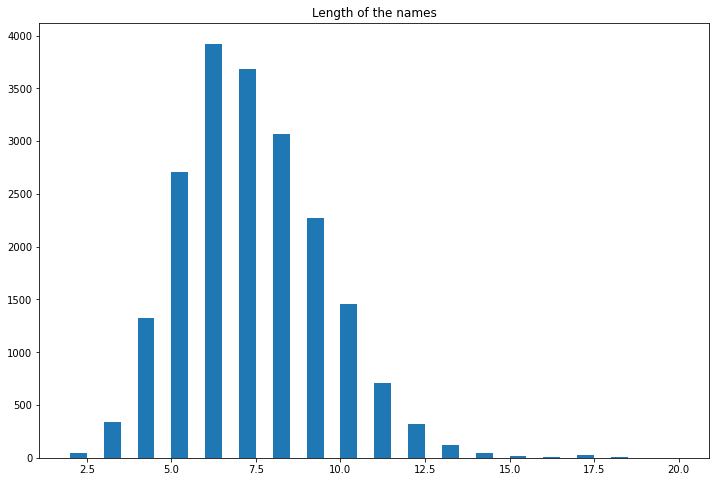

In [ ]:
plt.figure(figsize=(12,8))
plt.hist([len(a) for a in names], bins=36)
plt.title("Length of the names")
plt.show();

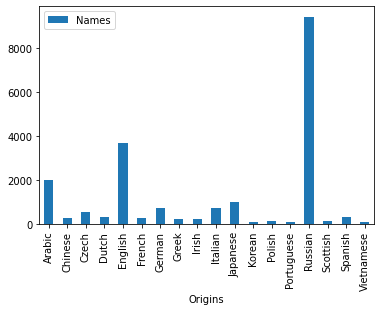

In [ ]:
df.groupby(['Origins']).count().plot(kind='bar')

# Look at the data

In [ ]:
def tokenize(x):
  """
  Tokenize x
  x: list of sentences/strings to be tokenized
  returns : tuple of (Tokenized X data, tokenizer used to tokenize x)
  """
  x_tk = Tokenizer(char_level=True, lower=True)
  x_tk.fit_on_texts(x)
  vocab_size = x_tk.word_index
  print('Found %s unique tokens.' % len(vocab_size))
  return x_tk.texts_to_sequences(x), x_tk
  

In [ ]:
text_tokenized, text_tokenizer = tokenize(names)

Found 58 unique tokens.


In [ ]:
for sample_i, (sent, token_sent) in enumerate(zip(names[:10], text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))


Sequence 1 in x
  Input:  Aalsburg
  Output: [1, 1, 10, 7, 16, 13, 6, 18]
Sequence 2 in x
  Input:  Aalst
  Output: [1, 1, 10, 7, 12]
Sequence 3 in x
  Input:  Aarle
  Output: [1, 1, 6, 10, 3]
Sequence 4 in x
  Input:  Achteren
  Output: [1, 19, 8, 12, 3, 6, 3, 5]
Sequence 5 in x
  Input:  Achthoven
  Output: [1, 19, 8, 12, 8, 2, 11, 3, 5]
Sequence 6 in x
  Input:  Adrichem
  Output: [1, 15, 6, 4, 19, 8, 3, 14]
Sequence 7 in x
  Input:  Aggelen
  Output: [1, 18, 18, 3, 10, 3, 5]
Sequence 8 in x
  Input:  Agteren
  Output: [1, 18, 12, 3, 6, 3, 5]
Sequence 9 in x
  Input:  Agthoven
  Output: [1, 18, 12, 8, 2, 11, 3, 5]
Sequence 10 in x
  Input:  Akkeren
  Output: [1, 9, 9, 3, 6, 3, 5]


In [ ]:
def pad(x, length=18):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    # Find the length of the longest string in the dataset. 

    padded = pad_sequences(x, maxlen=length, padding='post')
    return padded
    

In [ ]:
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized[:10], test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))


Sequence 1 in x
  Input:  [ 1  1 10  7 16 13  6 18]
  Output: [ 1  1 10  7 16 13  6 18  0  0  0  0  0  0  0  0  0  0]
Sequence 2 in x
  Input:  [ 1  1 10  7 12]
  Output: [ 1  1 10  7 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
Sequence 3 in x
  Input:  [ 1  1  6 10  3]
  Output: [ 1  1  6 10  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
Sequence 4 in x
  Input:  [ 1 19  8 12  3  6  3  5]
  Output: [ 1 19  8 12  3  6  3  5  0  0  0  0  0  0  0  0  0  0]
Sequence 5 in x
  Input:  [ 1 19  8 12  8  2 11  3  5]
  Output: [ 1 19  8 12  8  2 11  3  5  0  0  0  0  0  0  0  0  0]
Sequence 6 in x
  Input:  [ 1 15  6  4 19  8  3 14]
  Output: [ 1 15  6  4 19  8  3 14  0  0  0  0  0  0  0  0  0  0]
Sequence 7 in x
  Input:  [ 1 18 18  3 10  3  5]
  Output: [ 1 18 18  3 10  3  5  0  0  0  0  0  0  0  0  0  0  0]
Sequence 8 in x
  Input:  [ 1 18 12  3  6  3  5]
  Output: [ 1 18 12  3  6  3  5  0  0  0  0  0  0  0  0  0  0  0]
Sequence 9 in x
  Input:  [ 1 18 12  8  2 11  3  5]
  Output: [ 1 18 12  8  2

In [ ]:
def preprocess(x):
    """
    Preprocess x and y
    :param x: Feature List of Names

    :return: Tuple of padded and tokenized names
    """
    preprocess_x, x_tk = tokenize(x)


    preprocess_x = pad(preprocess_x)


    return preprocess_x, x_tk

X_preproc, x_tokenizer = preprocess(names)
X_preproc.shape

Found 58 unique tokens.


(20074, 18)

# Splitting the data
* Converting string values to integers

In [ ]:
Y = pd.get_dummies(df['Origins']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (20074, 18)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_preproc,Y, test_size = 0.10)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(18066, 18) (18066, 18)
(2008, 18) (2008, 18)


numpy.ndarray

## Fairly Straightforward Model
* The 'vocabulary' in this case corresponds to the number of unique letters as established by `tokenizer.word_index`. In this case, is 58+1
* Output dimension represents the number of dimensions we wish to embed into. This is a fairly arbitrary number, as each word will be represented by a vector of this much dimensions. In our case, words are individual letters. 
* Input length is the length of the longest word, here it was decided to be 18 after padding. 

In [ ]:
vocab = 59
max_dim = 32

In [ ]:
K.clear_session()
model = Sequential()
model.add(Embedding(input_dim=vocab, output_dim=max_dim, input_length=X_preproc.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(18,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 100)           5900      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 18, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 18)                1818      
Total params: 88,118
Trainable params: 88,118
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

In [ ]:
h = model.fit(X_train, Y_train, batch_size=20, epochs=40, validation_split=0.2, verbose=0)

Epoch 1/40
723/723 [==============================] - 60s 83ms/step - loss: 1.6485 - accuracy: 0.5279 - val_loss: 1.3407 - val_accuracy: 0.6115
Epoch 2/40
723/723 [==============================] - 60s 83ms/step - loss: 1.2879 - accuracy: 0.6214 - val_loss: 1.1722 - val_accuracy: 0.6635
Epoch 3/40
723/723 [==============================] - 60s 83ms/step - loss: 1.1560 - accuracy: 0.6502 - val_loss: 1.0517 - val_accuracy: 0.6937
Epoch 4/40
723/723 [==============================] - 62s 85ms/step - loss: 1.0351 - accuracy: 0.6891 - val_loss: 0.9306 - val_accuracy: 0.7247
Epoch 5/40
723/723 [==============================] - 60s 83ms/step - loss: 0.9303 - accuracy: 0.7187 - val_loss: 0.8419 - val_accuracy: 0.7465
Epoch 6/40
723/723 [==============================] - 60s 84ms/step - loss: 0.8536 - accuracy: 0.7404 - val_loss: 0.7926 - val_accuracy: 0.7662
Epoch 7/40
723/723 [==============================] - 60s 83ms/step - loss: 0.7936 - accuracy: 0.7572 - val_loss: 0.7763 - val_accuracy:

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

63/63 [==============================] - 1s 9ms/step - loss: 0.6160 - accuracy: 0.8252
Test set
  Loss: 0.616
  Accuracy: 0.825


In [ ]:
def predictor(name,model):

  labels = ['Arabic','Chinese','Czech','Dutch','English','French','German','Greek','Irish','Italian','Japanese', 'Korean','Polish','Portuguese','Russian','Scottish','Spanish','Vietnamese']
  tokenizer = Tokenizer(char_level=True, lower=True)
  tokenizer.fit_on_texts(df['Names'].values)
  seq = tokenizer.texts_to_sequences([name])
  padded = pad_sequences(seq, maxlen=18, padding='post')
  pred = model.predict(padded)
  pred_results=pd.DataFrame(pred)
  pred_results.columns=labels
  nat = labels[np.argmax(pred)]
  print(f'Name nationality is likely to be {nat}')
  display(pred_results)



In [ ]:
predictor("Carmen",model)

Name nationality is likely to be English


,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
0,8.177579e-08,0.000013,0.003548,0.197719,0.741821,0.000832,0.001562,0.000004,0.049952,0.000237,0.000132,0.00002,0.000465,9.462227e-07,0.000262,0.003364,0.000045,0.000023


## Using GRU

In [ ]:
K.clear_session()
m2 = Sequential()
m2.add(Embedding(vocab, max_dim, input_length=X_preproc.shape[1]))
m2.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
m2.add(Dense(18, activation='softmax'))

m2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 32)            1888      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 18)                594       
Total params: 8,818
Trainable params: 8,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
m2.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

In [ ]:
h = m2.fit(X_train, Y_train, batch_size=20, epochs=40, validation_split=0.2, verbose=0)

In [ ]:
accr = m2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

63/63 [==============================] - 0s 6ms/step - loss: 0.6593 - accuracy: 0.8018
Test set
  Loss: 0.659
  Accuracy: 0.802


In [ ]:
predictor("Carmen",m2)

Name nationality is likely to be English


,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
0,0.000139,0.000061,0.019844,0.091574,0.617745,0.041028,0.087542,0.000167,0.089922,0.00855,0.000031,0.000023,0.002314,0.000777,0.014978,0.021578,0.003518,0.000209
